In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pymer4.models import Lmer,Lm
from matplotlib import cm
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [30]:
pd.set_option('display.max_columns', None)

In [31]:
concatenated_df = pd.read_pickle('./concatenated_df_oct.pkl')
age = pd.read_pickle('./age_oct.pkl')


average age: 29.560909090909092
average age controls: 34.118125
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


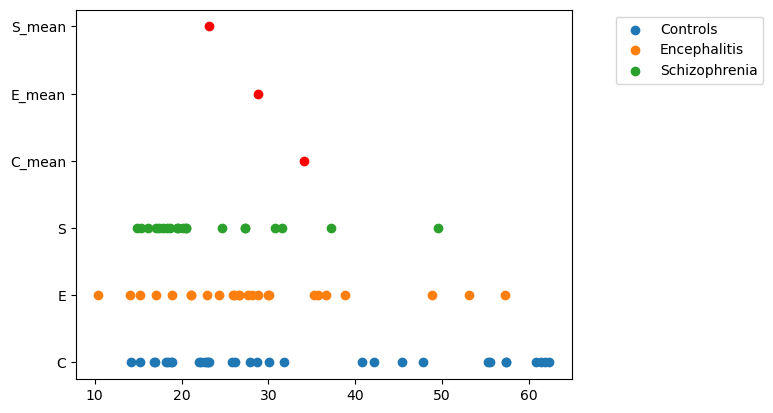

In [32]:
age['Group'] = age['Subject'].str[0]
age.tail(9)


# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
  
plt.errorbar(np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), "C_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']), "E_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']), "S_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')

plt.show()

In [33]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
#data = concatenated_df[crs1]
data=concatenated_df

# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')


# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)


/tmp/ipykernel_2645804/3263902381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## AGE COMPRISON between 20- and 20+

In [34]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0  16147  0.390689  1406.81      1407.16  1407.77  1408.12      1.64   
1  11458  0.391044  1408.03      1408.31  1408.67  1409.26      1.50   
2  14355  0.393181  1415.75      1416.35  1416.68  1416.93      1.48   
3  11459  0.393536  1417.03      1417.28  1417.47  1417.69      0.96   
4  14356  0.397639  1431.74      1431.96  1432.18  1432.82      1.32   

   ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
0  -54.438037   56.538966  110.977003  317.077151   0.609756      2      F4   
1  -59.791872   41.681846  101.473718  362.406135   0.666667      2      F7   
2  -43.574775   38.377907   81.952683  136.587804   0.675676      2      Fz   
3  -82.223783   45.544797  127.768579  511.074318   1.041667      2      F7   
4  -42.860329   34.949432   77.809761  353.680731   0.757576      2      Fz   

   IdxChannel Group Subject Session    Age Machine ConfArousal Position  
0           9     C     C02       1  22.91       O           0        F  
1           6     C     C02       1  22.91       O           0        F  
2           8     C     C02       1  22.91       O           0        F  
3           6     C     C02       1  22.91       O           0        F  
4           8     C     C02       1  22.91       O           0        F

In [35]:
data_F[data_F['Stage'] == 3]['Start']

47        0.673000
48        0.679381
49        0.679381
50        0.679381
51        0.679381
            ...   
819379    5.718425
819380    5.722625
819381    5.722628
819382    5.722950
819570    6.576497
Name: Start, Length: 543409, dtype: float64

In [36]:
data_F['Start']

0         0.390689
1         0.391044
2         0.393181
3         0.393536
4         0.397639
            ...   
820015    7.966611
820016    7.966636
820017    7.971547
820018    7.982069
820019    7.982247
Name: Start, Length: 820020, dtype: float64

data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

def first_block_all(data, data_n3, bin_size, threshold_sum):
    
    block2 = False
    
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 15)[0]
    nz_indices3 = np.where(hist_valuesn3 > 7)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]

    for i in range(1, len(nz_edges)): 
        print(cbins)
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    if block2 == True:
                        return cbins[0]
                    else:
                        cbins = [nz_edges[i]] 
                        block2 = True

                if nz_edges[i] in nz_edges3:
                    try:
                        cbins = [next(x for x in nz_edges3 if x > nz_edges[i])]
                    except:
                        return None
            
    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
        return cbins[0]
    return None

data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=350
    )
).reset_index(name='Start_Block')

In [37]:
#1st block detect

data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

def first_block_all(data, data_n3, bin_size, threshold_sum):
    
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 15)[0]
    nz_indices3 = np.where(hist_valuesn3 > 7)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    return nz_edges[i]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
            
    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                return nz_edges[i]
    return None


data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=350
    )
).reset_index(name='End_Block1')





In [38]:
data_F['end_b1'] = data_F['Id'].map(data_starts.set_index('Id')['End_Block1'])
data_b2F = data_F.copy()
data_b2F['time_rel'] = data_b2F['Start'] - (data_b2F['end_b1'])
data_b2F = data_F[(data_b2F['time_rel'] >= 0)]


In [39]:
data_b2F['Id'] = data_b2F['Subject'] + '_' + data_b2F['Session'].astype(str)

def first_block_all(data, data_n3, bin_size, threshold_sum):
    
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 15)[0]
    nz_indices3 = np.where(hist_valuesn3 > 7)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    return cbins[0]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
            
    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                return cbins[0]
    return None


data_starts = data_b2F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=350
    )
).reset_index(name='Start_Block')



/tmp/ipykernel_2645804/3863918533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_b2F['Id'] = data_b2F['Subject'] + '_' + data_b2F['Session'].astype(str)


In [40]:
data_b2F['N23_times'] = data_b2F['Id'].map(data_starts.set_index('Id')['Start_Block'])
data_b2F['time_rel'] = data_b2F['Start'] - data_b2F['N23_times']
data_b2F = data_b2F[data_b2F['time_rel'] >= 0]

data_b2F['N3_times'] = data_b2F['Start'].where(data_b2F['Stage'] == 3)
N3_start_time = data_b2F.groupby(['Subject','Session'])['N3_times'].transform('min')
data_b2F['N3_times'] = N3_start_time
data_b2F['time_rel'] = data_b2F['Start'] - data_b2F['N3_times']

data_b2F['diff'] = data_b2F['N3_times'] - data_b2F['N23_times']
data_allF = data_b2F[(data_b2F['time_rel'] <= 0.5) & (data_b2F['time_rel'] >= 0)]


data_allF = data_allF.dropna(subset=['Age'])

/tmp/ipykernel_2645804/3379367739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_b2F['N23_times'] = data_b2F['Id'].map(data_starts.set_index('Id')['Start_Block'])
/tmp/ipykernel_2645804/3379367739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_b2F['time_rel'] = data_b2F['Start'] - data_b2F['N23_times']


data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

data_F['condBlock'] = 0
for index, row in data_F.iterrows():
    if row['Stage'] == 3:
        t0 = row['Start']
        t0_5 = t0 + 0.5
        id = row['Id']
        data_Id = data_F.where(data_F['Id'] == id)
        data_Id['N3'] = data_Id['Stage'].apply(lambda x: 1 if x == 3 else 0)
        c = data_Id[(data_Id['Start'] > t0) & (data_Id['Start'] <= t0_5)] 
        c = c['N3'].eq(1).sum()
        if c >= 100:
            row['condBlock'] = 1

In [41]:
result_df = data_allF.groupby('Id')['N3_times'].first().reset_index()
result_df[0:60]


Id  N3_times
0   C02_1  1.510553
1   C03_1  3.708961
2   C03_4  4.683700
3   C04_1  1.356381
4   C05_4  1.653658
5   C06_1  1.767608
6   C06_4  1.741733
7   C08_4  2.058422
8   C10_1  1.660744
9   C11_1  2.067422
10  C12_1  1.805856
11  C13_1  2.013278
12  C13_4  2.959486
13  C14_1  2.042064
14  C14_4  2.417319
15  C15_1  4.904742
16  C15_4  1.666678
17  C16_4  3.214903
18  C17_1  1.626956
19  C18_1  4.106856
20  C20_1  2.403706
21  C20_4  2.800758
22  C22_1  2.008553
23  C23_1  3.371975
24  C23_4  2.250517
25  C24_1  3.112431
26  C28_1  2.151644
27  C28_4  2.050358
28  C29_1  2.251386
29  C29_4  2.453503
30  C30_1  3.337119
31  C34_1  3.912294
32  E01_2  2.410933
33  E02_1  2.384911
34  E02_2  2.200458
35  E02_3  1.977372
36  E02_4  2.176386
37  E03_1  1.667253
38  E03_2  2.000058
39  E03_3  2.222106
40  E03_4  2.206506
41  E04_1  2.241733
42  E04_2  2.201289
43  E04_3  2.060511
44  E04_4  2.589414
45  E05_1  4.953886
46  E06_1  1.259903
47  E07_1  0.676775
48  E07_2  1.450119
49  E07_3  1.184433
50  E07_4  2.450294
51  E08_2  2.560883
52  E08_3  2.404619
53  E08_4  1.951347
54  E10_3  3.392172
55  E10_4  2.475003
56  E11_1  1.205594
57  E11_2  1.520881
58  E11_4  1.959881
59  E13_1  1.975989

In [42]:
data_allF[data_allF['Id'] == 'C02_1'].head(9)

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
2112  13243  1.510553  5438.30      5438.52  5438.72  5438.92      0.93   
2113  16604  1.511139  5440.40      5440.66  5440.84  5441.05      0.95   
2114  14896  1.517553  5463.51      5463.74  5464.03  5464.40      1.21   
2115  13244  1.517558  5463.53      5463.76  5464.05  5464.39      1.18   
2116  11816  1.518822  5468.09      5468.37  5468.57  5468.79      1.03   
2117  16605  1.522675  5481.88      5482.12  5482.34  5482.60      0.97   
2118  13245  1.522683  5481.92      5482.17  5482.35  5482.61      0.95   
2119  14897  1.522683  5481.92      5482.16  5482.37  5482.63      0.97   
2120  13246  1.525600  5492.40      5492.63  5492.82  5493.48      1.32   

      ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
2112  -41.434871   36.925777   78.360648  356.184764   1.075269      3   
2113  -50.769285   25.433997   76.203283  293.089550   1.052632      3   
2114  -49.050950   63.916516  112.967467  491.162898   0.826446      3   
2115  -45.807997   58.153625  103.961621  452.007050   0.847458      3   
2116  -49.297986   29.879534   79.177520  282.776856   0.970874      3   
2117  -55.561751   41.980471   97.542222  406.425925   1.030928      3   
2118  -59.369594   29.677551   89.047145  356.188578   1.052632      3   
2119  -75.623334   49.104407  124.727740  519.698917   1.030928      3   
2120  -52.143511   31.545200   83.688711  363.863961   0.757576      3   

     Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
2112      F3           7     C     C02       1  22.91       O           0   
2113      F4           9     C     C02       1  22.91       O           0   
2114      Fz           8     C     C02       1  22.91       O           0   
2115      F3           7     C     C02       1  22.91       O           0   
2116      F7           6     C     C02       1  22.91       O           0   
2117      F4           9     C     C02       1  22.91       O           0   
2118      F3           7     C     C02       1  22.91       O           0   
2119      Fz           8     C     C02       1  22.91       O           0   
2120      F3           7     C     C02       1  22.91       O           0   

     Position     Id  end_b1  N23_times  time_rel  N3_times      diff  
2112        F  C02_1    1.45        1.5  0.000000  1.510553  0.010553  
2113        F  C02_1    1.45        1.5  0.000586  1.510553  0.010553  
2114        F  C02_1    1.45        1.5  0.007000  1.510553  0.010553  
2115        F  C02_1    1.45        1.5  0.007006  1.510553  0.010553  
2116        F  C02_1    1.45        1.5  0.008269  1.510553  0.010553  
2117        F  C02_1    1.45        1.5  0.012122  1.510553  0.010553  
2118        F  C02_1    1.45        1.5  0.012131  1.510553  0.010553  
2119        F  C02_1    1.45        1.5  0.012131  1.510553  0.010553  
2120        F  C02_1    1.45        1.5  0.015047  1.510553  0.010553

In [43]:

#SEPARATE BINNED DATA_F in 20- and 20+

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  # Adjust the number of bins as needed


print (len(bins_data_F))

#older group
bdf_o = bins_data_F[bins_data_F['Age'] >= 20]
print(len(bdf_o))

bdf_o = bdf_o.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_o['Group'] = bdf_o['Subject'].str[0]
mdf_o = bdf_o.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#younger group
bdf_y = bins_data_F[bins_data_F['Age'] < 20]
print(len(bdf_y))

bdf_y = bdf_y.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_y['Group'] = bdf_y['Subject'].str[0]
mdf_y = bdf_y.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#all
bins_data_F = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


55905
25977
29928


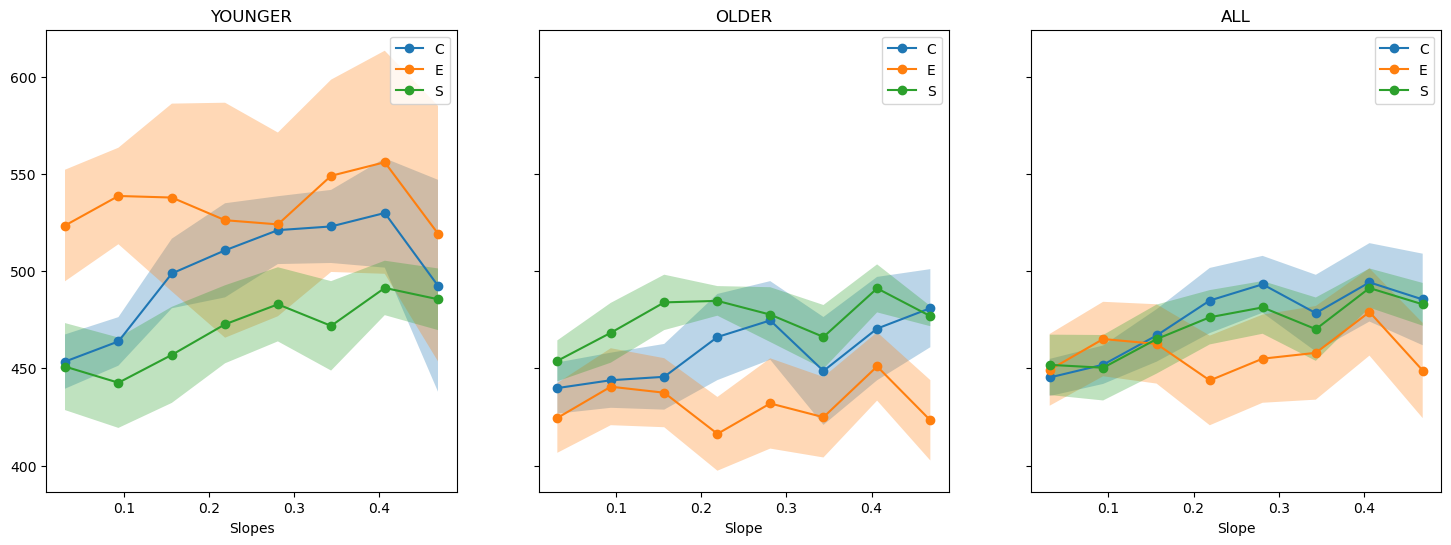

In [44]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6), sharex = 'all', sharey = 'all')

# Plot the individual curves for each name
mdf_o["time_rel_c"] = mdf_o["time_rel"].apply(lambda x: x.mid)
mdf_y["time_rel_c"] = mdf_y["time_rel"].apply(lambda x: x.mid)
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mdf_o['time_rel_c'].unique()

#YOUNGER
ax[0].set_title('YOUNGER')
for name, group in mdf_y.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].set_xlabel('Time')
ax[0].set_xlabel('Slopes')
ax[0].legend()

#OLDER
ax[1].set_title('OLDER')
for name, group in mdf_o.groupby('Group'):
    ax[1].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[1].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[1].set_xlabel('Time')
ax[1].set_xlabel('Slope')
ax[1].legend()

#ALL
ax[2].set_title('ALL')
for name, group in mean_data_F.groupby('Group'):
    ax[2].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[2].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[2].set_xlabel('Time')
ax[2].set_xlabel('Slope')
ax[2].legend()



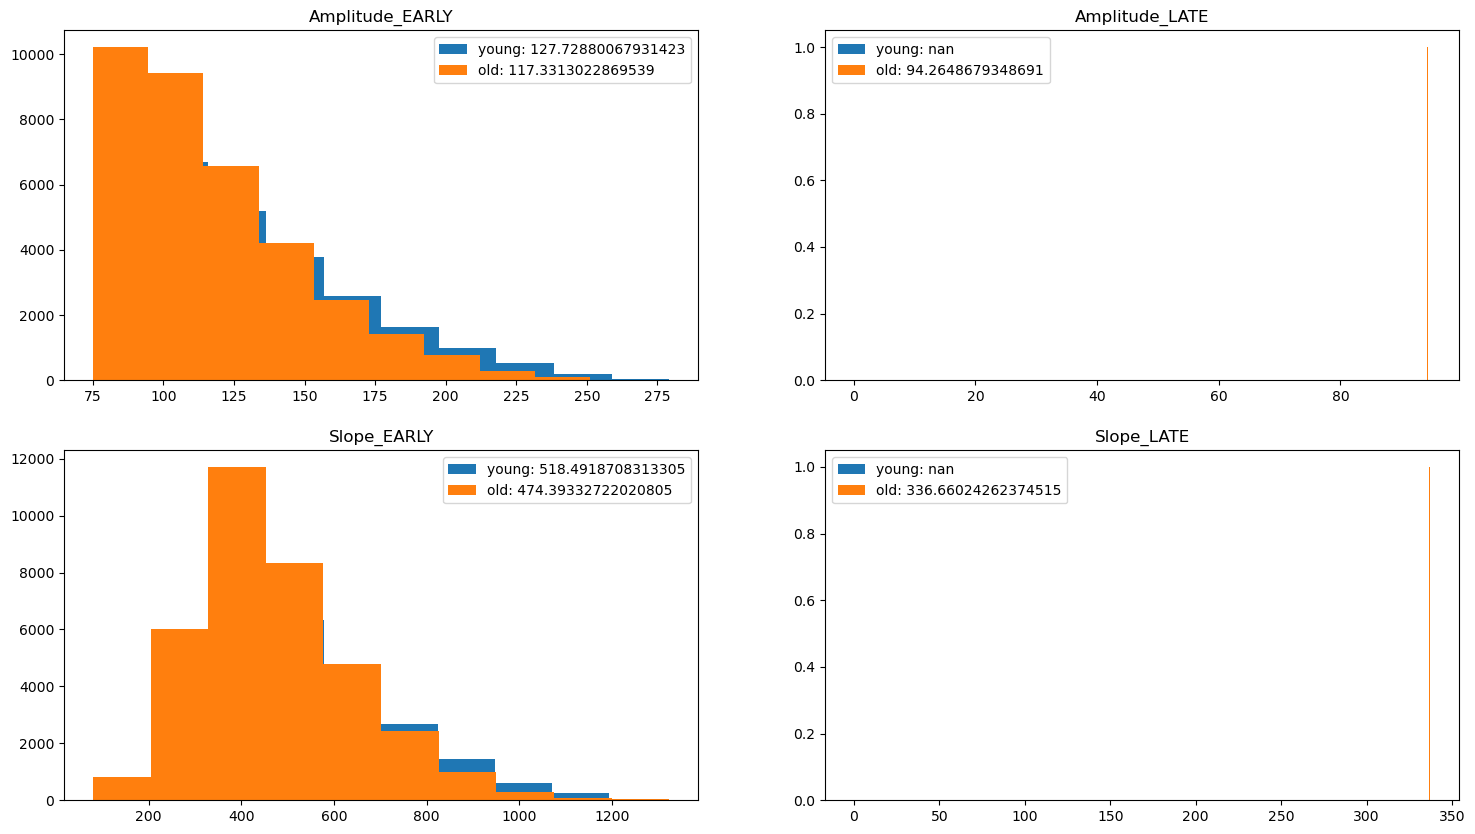

In [45]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))


data_young = data_allF[data_allF['Age'] < 20]
data_old = data_allF[data_allF['Age'] >= 20]


data_early_young = data_young[data_young['time_rel'] <= 0.3]
data_late_young = data_young[data_young['time_rel'] >= 0.5]
data_early_old = data_old[data_old['time_rel'] <= 0.3]
data_late_old = data_old[data_old['time_rel'] >= 0.5]


ax[0,0].hist(data_early_young.PTP, label = 'young: ' + str(np.mean(data_early_young.PTP)) )
ax[0,0].hist(data_early_old.PTP, label = 'old: ' + str(np.mean(data_early_old.PTP)))
ax[0,0].set_title('Amplitude_EARLY')
ax[0,0].legend()

ax[0,1].hist(data_late_young.PTP, label = 'young: ' + str(np.mean(data_late_young.PTP)) )
ax[0,1].hist(data_late_old.PTP, label = 'old: ' + str(np.mean(data_late_old.PTP)))
ax[0,1].set_title('Amplitude_LATE')
ax[0,1].legend()

ax[1,0].hist(data_early_young.Slope, label = 'young: ' + str(np.mean(data_early_young.Slope)) )
ax[1,0].hist(data_early_old.Slope, label = 'old: ' + str(np.mean(data_early_old.Slope)))
ax[1,0].set_title('Slope_EARLY')
ax[1,0].legend()

ax[1,1].hist(data_late_young.Slope, label = 'young: ' + str(np.mean(data_late_young.Slope)) )
ax[1,1].hist(data_late_old.Slope, label = 'old: ' + str(np.mean(data_late_old.Slope)))
ax[1,1].set_title('Slope_LATE')
ax[1,1].legend()


       Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
2112  13243  1.510553  5438.30      5438.52  5438.72  5438.92      0.93   
2113  16604  1.511139  5440.40      5440.66  5440.84  5441.05      0.95   
2114  14896  1.517553  5463.51      5463.74  5464.03  5464.40      1.21   
2115  13244  1.517558  5463.53      5463.76  5464.05  5464.39      1.18   
2116  11816  1.518822  5468.09      5468.37  5468.57  5468.79      1.03   

      ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
2112  -41.434871   36.925777   78.360648  356.184764   1.075269      3   
2113  -50.769285   25.433997   76.203283  293.089550   1.052632      3   
2114  -49.050950   63.916516  112.967467  491.162898   0.826446      3   
2115  -45.807997   58.153625  103.961621  452.007050   0.847458      3   
2116  -49.297986   29.879534   79.177520  282.776856   0.970874      3   

     Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
2112      F3           7   

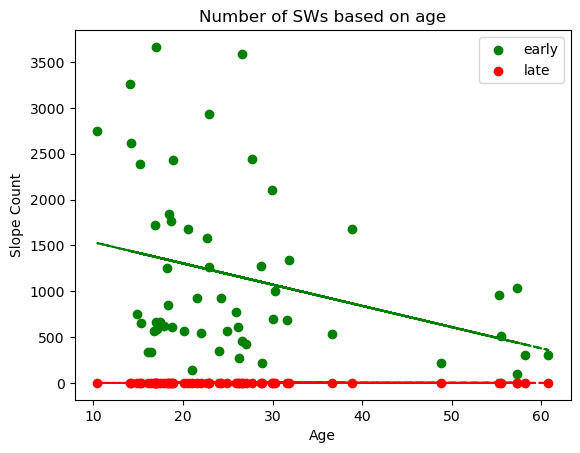

In [46]:

x_early_list = []
y_early_list = []
x_late_list = []
y_late_list = []

for name, Subject in data_allF.groupby('Subject'):
    data_early = Subject[Subject['time_rel'] <= 0.3]
    data_late = Subject[Subject['time_rel'] >= 0.5]

    print(data_early[0:5])

    x_early_list.append(Subject['Age'].unique()[0])
    y_early_list.append(data_early['Slope'].count())

    x_late_list.append(Subject['Age'].unique()[0])
    y_late_list.append(data_late['Slope'].count())

plt.scatter(x_early_list, y_early_list, marker='o', c='green', label='early')
plt.scatter(x_late_list, y_late_list, marker='o', c='red', label='late')

print(len(x_early_list))

early_fit = np.polyfit(x_early_list, y_early_list, 1)
late_fit = np.polyfit(x_late_list, y_late_list, 1)

plt.plot(x_early_list, np.polyval(early_fit, x_early_list), color='green', linestyle='--')
plt.plot(x_late_list, np.polyval(late_fit, x_late_list), color='red', linestyle='--')

plt.title('Number of SWs based on age')
plt.xlabel('Age')
plt.ylabel('Slope Count')
plt.legend()
plt.show()



# Age modelling for controls

In [47]:
bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
2112  13243  1.510553  5438.30      5438.52  5438.72  5438.92      0.93   
2113  16604  1.511139  5440.40      5440.66  5440.84  5441.05      0.95   
2114  14896  1.517553  5463.51      5463.74  5464.03  5464.40      1.21   
2115  13244  1.517558  5463.53      5463.76  5464.05  5464.39      1.18   
2116  11816  1.518822  5468.09      5468.37  5468.57  5468.79      1.03   

      ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
2112  -41.434871   36.925777   78.360648  356.184764   1.075269      3   
2113  -50.769285   25.433997   76.203283  293.089550   1.052632      3   
2114  -49.050950   63.916516  112.967467  491.162898   0.826446      3   
2115  -45.807997   58.153625  103.961621  452.007050   0.847458      3   
2116  -49.297986   29.879534   79.177520  282.776856   0.970874      3   

     Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
2112      F3           7     C     C02       1  22.91       O           0   
2113      F4           9     C     C02       1  22.91       O           0   
2114      Fz           8     C     C02       1  22.91       O           0   
2115      F3           7     C     C02       1  22.91       O           0   
2116      F7           6     C     C02       1  22.91       O           0   

     Position     Id  end_b1  N23_times  time_rel  N3_times      diff  
2112        F  C02_1    1.45        1.5  0.000000  1.510553  0.010553  
2113        F  C02_1    1.45        1.5  0.000586  1.510553  0.010553  
2114        F  C02_1    1.45        1.5  0.007000  1.510553  0.010553  
2115        F  C02_1    1.45        1.5  0.007006  1.510553  0.010553  
2116        F  C02_1    1.45        1.5  0.008269  1.510553  0.010553

In [48]:
# Obtain first hour of SWS:

#BINS DATA FRAME _ CONTROLS

bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c['time_rel'] = pd.cut(bdf_c['time_rel'], bins=8)  # Adjust the number of bins as needed
print(len(bdf_c['Id'].unique()))

bdf_c = bdf_c.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_c['Group'] = bdf_c['Subject'].str[0]

age_c = age[age['Group']=='C']
#age_c = age_c[age_c['Session']==1]

bdf_c = bdf_c.merge(age_c)
bdf_c = bdf_c.dropna(subset=['Age'])
bdf_c.head()


32


Session Subject           time_rel       Slope Group            Birthdate  \
0        1     C02  (-0.0005, 0.0625]  424.565122     C  1994-05-28 00:00:00   
1        1     C02    (0.0625, 0.125]  470.189602     C  1994-05-28 00:00:00   
2        1     C02     (0.125, 0.188]  486.544316     C  1994-05-28 00:00:00   
3        1     C02      (0.188, 0.25]  524.869624     C  1994-05-28 00:00:00   
4        1     C02      (0.25, 0.312]  536.171388     C  1994-05-28 00:00:00   

              Testdate    Age  
0  2017-04-26 00:00:00  22.91  
1  2017-04-26 00:00:00  22.91  
2  2017-04-26 00:00:00  22.91  
3  2017-04-26 00:00:00  22.91  
4  2017-04-26 00:00:00  22.91

[0.031 0.09375 0.1565 0.219 0.281 0.3435 0.4065 0.469]


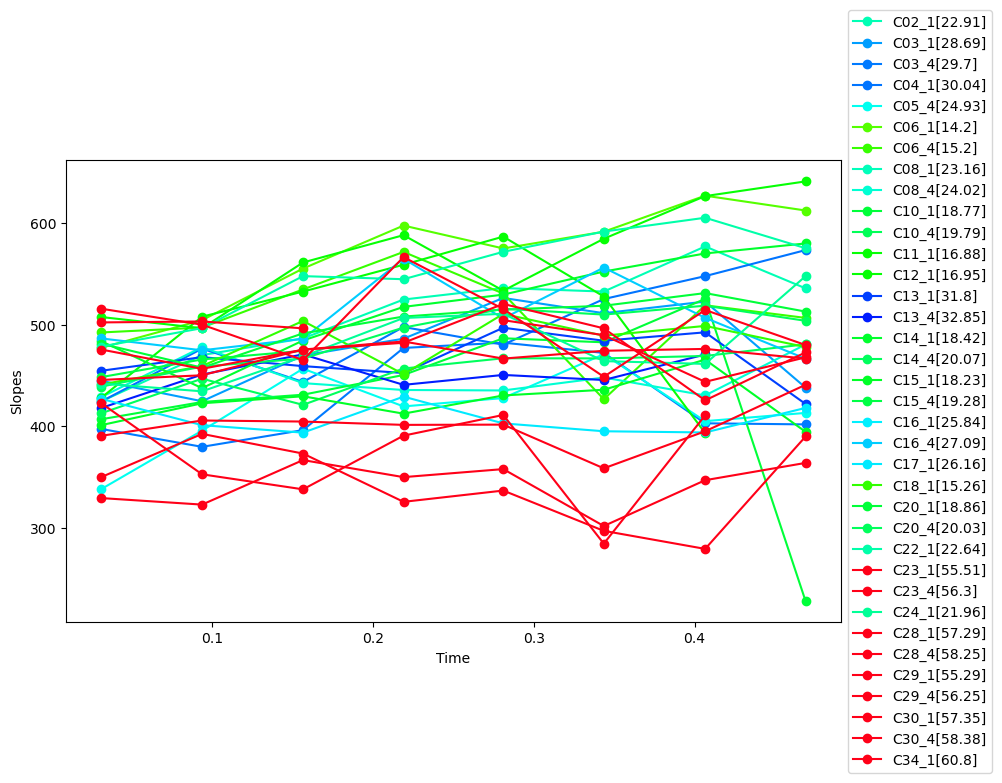

In [49]:

plt.figure(figsize=(10, 6))

# Plot the individual curves for each age

bdf_c["time_rel_c"] = bdf_c["time_rel"].apply(lambda x: x.mid).astype('object')
time_intervals = bdf_c['time_rel_c'].unique()
print(time_intervals)
bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
for name, Id in bdf_c.groupby('Id'):
    plt.plot(time_intervals, Id['Slope'], marker='o', c = cm.hsv(Id['Age'].unique()[0]/50), label=str(name) + str(Id['Age'].unique()))

plt.xlabel('Time')
plt.ylabel('Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



[0.031 0.09375 0.1565 0.219 0.281 0.3435 0.4065 0.469]


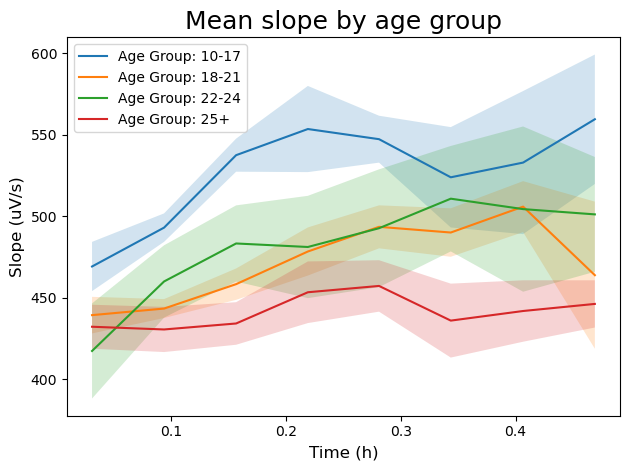

In [50]:
bins = [10, 18, 22, 25, np.inf]
labels = ['10-17','18-21', '22-24','25+']
bdf_c['age_group'] = pd.cut(bdf_c['Age'], bins=bins, labels=labels, right=False)


print(time_intervals)

for age_group, group_data in bdf_c.groupby('age_group'):
    mean_score = group_data.groupby('time_rel_c')['Slope'].mean()
    sem_score = group_data.groupby('time_rel_c')['Slope'].sem()
    plt.plot(time_intervals, mean_score.values, label=f'Age Group: {age_group}')
    plt.fill_between(mean_score.index, mean_score - sem_score, mean_score + sem_score, alpha=0.2)


plt.xlabel('Time (h)',fontsize=12)
plt.ylabel('Slope (uV/s)',fontsize=12)
plt.title('Mean slope by age group', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('Age_dist')
plt.show()

In [51]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50
print(len(daf_c['Id'].unique()))

32


[]

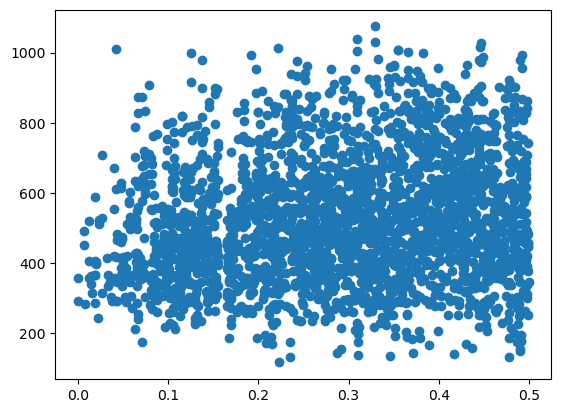

In [52]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
daf_c = daf_c[daf_c['Id'] == 'C02_1']
plt.scatter(daf_c.time_rel,daf_c.Slope)
plt.plot()


In [53]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
daf_c.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
2112  13243  1.510553  5438.30      5438.52  5438.72  5438.92      0.93   
2113  16604  1.511139  5440.40      5440.66  5440.84  5441.05      0.95   
2114  14896  1.517553  5463.51      5463.74  5464.03  5464.40      1.21   
2115  13244  1.517558  5463.53      5463.76  5464.05  5464.39      1.18   
2116  11816  1.518822  5468.09      5468.37  5468.57  5468.79      1.03   

      ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
2112  -41.434871   36.925777   78.360648  356.184764   1.075269      3   
2113  -50.769285   25.433997   76.203283  293.089550   1.052632      3   
2114  -49.050950   63.916516  112.967467  491.162898   0.826446      3   
2115  -45.807997   58.153625  103.961621  452.007050   0.847458      3   
2116  -49.297986   29.879534   79.177520  282.776856   0.970874      3   

     Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
2112      F3           7     C     C02       1  22.91       O           0   
2113      F4           9     C     C02       1  22.91       O           0   
2114      Fz           8     C     C02       1  22.91       O           0   
2115      F3           7     C     C02       1  22.91       O           0   
2116      F7           6     C     C02       1  22.91       O           0   

     Position     Id  end_b1  N23_times  time_rel  N3_times      diff  
2112        F  C02_1    1.45        1.5  0.000000  1.510553  0.010553  
2113        F  C02_1    1.45        1.5  0.000586  1.510553  0.010553  
2114        F  C02_1    1.45        1.5  0.007000  1.510553  0.010553  
2115        F  C02_1    1.45        1.5  0.007006  1.510553  0.010553  
2116        F  C02_1    1.45        1.5  0.008269  1.510553  0.010553

0
C02_1
[0.         0.00058611 0.007      ... 0.49894167 0.49926667 0.49963611]
[356.18476385 293.08954961 491.16289796 ... 253.31131266 742.1963159
 346.2039255 ]
1
C03_1
2
C03_4
3
C04_1
4
C05_4
5
C06_1
6
C06_4
7
C08_4
8
C10_1
9
C11_1
10
C12_1
11
C13_1
12
C13_4
13
C14_1
14
C14_4
15
C15_1
16
C15_4
17
C16_4
18
C17_1
19
C18_1
20
C20_1
21
C20_4
22
C22_1
23
C23_1
24
C23_4
25
C24_1
26
C28_1
27
C28_4
28
C29_1
29
C29_4
30
C30_1
31
C34_1


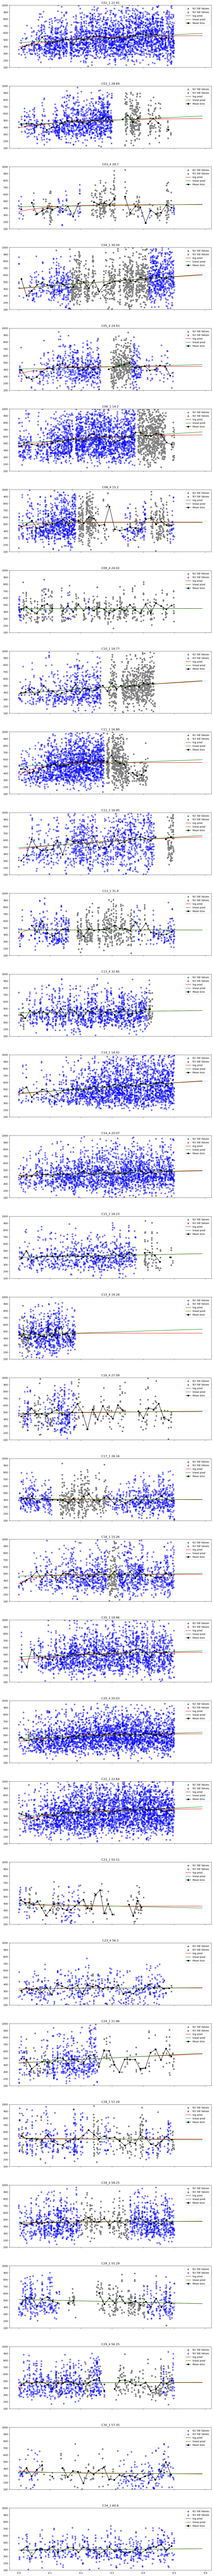

In [54]:

#LOG NO BINS
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50

def func(x, a, b, c):
    return a - (b * np.exp(-x/c))

def func_l(x, m,n):
    return m + n*x

x_list = []
a_list = []
b_list = []
c_list = []

m_list = []
n_list = []

# Get the number of subplots needed
num_subplots = len(daf_c['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 6*num_subplots),sharex=True, gridspec_kw={'hspace': 0.3})

for idx, (name, Subject) in enumerate(daf_c.groupby('Id')):
    print(idx)
    print(name)
    
    x = Subject.time_rel.values
    y = Subject.Slope.values

    if name == 'C02_1':
        print(x)
        print(y)

    popt, pcov = curve_fit(func, x, y, bounds=([0, -1000, 0], [1000, 1000, 5]))

    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

    poptl, pcovl = curve_fit(func_l, x, y, bounds=([0, -1000], [1000, 1000]))

    coef_m = popt[0]
    coef_n = popt[1]

    m_list.append(coef_m)
    n_list.append(coef_n)

    # Plot on the respective subplot
    x_time = np.arange(0,0.6,0.01)
    Subject_2 = Subject[Subject['Stage']==2]
    Subject_3 = Subject[Subject['Stage']==3]
    axs[idx].scatter(Subject_2.time_rel.values, Subject_2.Slope.values,c='gray',label='N2 SW Values')
    axs[idx].scatter(Subject_3.time_rel.values, Subject_3.Slope.values,c='blue',label='N3 SW Values', alpha=0.5)
    axs[idx].plot(x_time, func(x_time, popt[0], popt[1], popt[2]), color='red', label='log pred')
    axs[idx].plot(x_time, func_l(x_time, poptl[0], poptl[1]), color='green', label='lineal pred')
    axs[idx].set_title(name + ' ' + str(Subject['Age'].unique()[0]))
    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=30)
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid)
    time_intervals = bins_Subject['time_rel_c'].unique()
    axs[idx].plot(time_intervals, bins_Subject['Slope'], marker='o', c = 'black', label='Mean bins')
    axs[idx].set_ylim([100,1000])
    axs[idx].legend()


plt.show()
        



In [55]:
Subject.head()

Wave     Start   NegPeak  MidCrossing   PosPeak       End  Duration  \
253042  4646  3.912294  14084.49     14084.69  14084.91  14085.14      0.88   
253043  5356  3.912294  14084.48     14084.67  14084.90  14085.14      0.88   
253044  4178  3.914517  14093.07     14093.39  14093.68  14094.02      1.76   
253045  6106  3.914569  14092.91     14093.31  14093.71  14094.06      1.61   
253046  5357  3.914581  14092.97     14093.37  14093.71  14094.07      1.58   

        ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
253042  -46.040994   50.852958   96.893952  484.469759   1.136364      3   
253043  -45.742865   63.131690  108.874555  573.023975   1.136364      3   
253044  -43.607981   49.621915   93.229896  291.343426   0.568182      3   
253045  -58.874620   43.499720  102.374341  255.935852   0.621118      3   
253046  -52.813438   57.307587  110.121025  275.302561   0.632911      3   

       Channel  IdxChannel Group Subject Session   Age Machine ConfArousal  \
253042      F3           7     C     C34       1  60.8       O           0   
253043      Fz           8     C     C34       1  60.8       O           0   
253044      F7           6     C     C34       1  60.8       O           0   
253045      F4           9     C     C34       1  60.8       O           0   
253046      Fz           8     C     C34       1  60.8       O           0   

       Position     Id  end_b1  N23_times  time_rel  N3_times      diff   sAge  
253042        F  C34_1     3.6        3.9  0.000000  3.912294  0.012294  1.216  
253043        F  C34_1     3.6        3.9  0.000000  3.912294  0.012294  1.216  
253044        F  C34_1     3.6        3.9  0.002222  3.912294  0.012294  1.216  
253045        F  C34_1     3.6        3.9  0.002275  3.912294  0.012294  1.216  
253046        F  C34_1     3.6        3.9  0.002286  3.912294  0.012294  1.216

 _____________ Fitted Parameters M:
M: 471.4253470075821
N: -0.8449458875683249
 _____________ Fitted Parameters N:
a: -519.1619097556279
b: -803.9711052456763
c: 119.96077801767576
[[10562960.21847931 10062814.21208252 -2157870.49108822]
 [10062814.21208252  9588866.23032764 -2054381.6128812 ]
 [-2157870.49108822 -2054381.6128812    441685.42158331]]


Text(0.5, 0.98, 'Slope analysis')

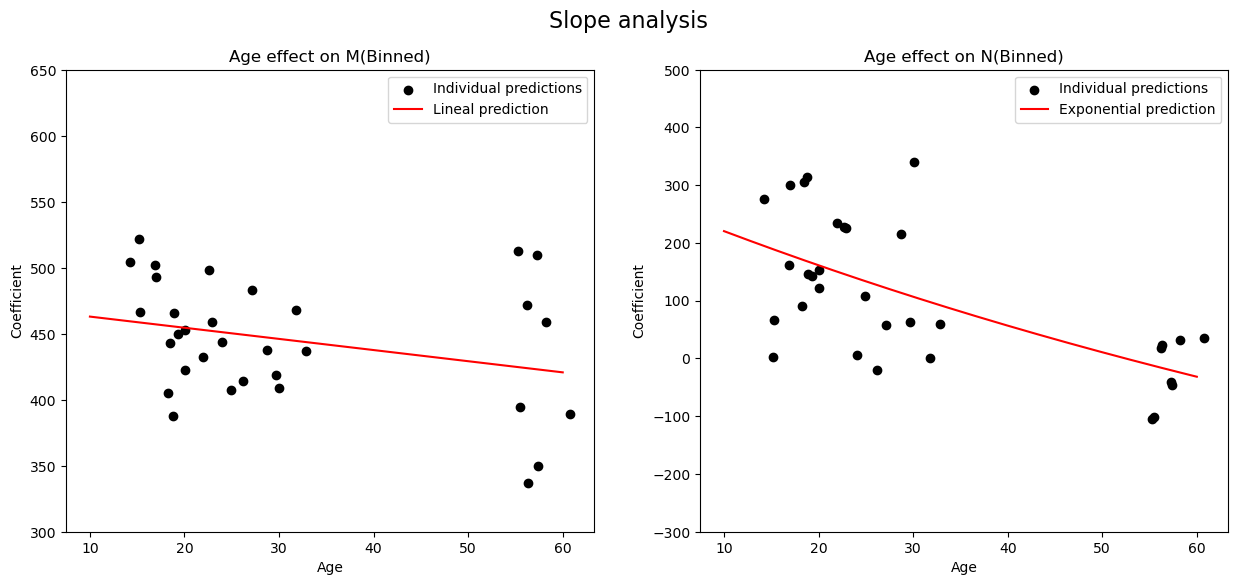

In [56]:
#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func_l(x, m, n):
    return m + n*x

def func_exp(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
m_list = []
n_list = []


for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func_l, x, y,bounds=([0,-1000],[1000,1000]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_m = popt[0]
    coef_n = popt[1]

    x_list.append(Subject['Age'].unique()[0])
    m_list.append(coef_m)
    n_list.append(coef_n)

fig, ax = plt.subplots(1, 2, figsize = (15, 6))

splot = 0
coef_names = ['M','N']
total_coefs = []

for coef_list in [m_list,n_list]:
    y_list = coef_list

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)

    if splot == 0:
        
        popt_t, pcov_t = curve_fit(func_l, x_sorted, y_sorted,bounds=([0,-1000],[1000,1000]))

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("M:", popt_t[0])
        print("N:", popt_t[1])

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])


        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_l(x_ages, popt_t[0], popt_t[1]), c='red', label='Lineal prediction')

    else: 
        popt_t, pcov_t,info, mesg,ier= curve_fit(func_exp, x_sorted, y_sorted, bounds=([-10000, -15000, 0], [10000, 0, 1000]), full_output=True)

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("a:", popt_t[0])
        print("b:", popt_t[1])
        print("c:", popt_t[2])
        print(pcov_t)

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])
        total_coefs.append(popt_t[2])
    

        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_exp(x_ages, popt_t[0], popt_t[1], popt_t[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')


    if splot == 0:
        ax[splot].set_ylim([300,650])
    else:
        ax[splot].set_ylim([-300,500])

    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



In [57]:
print(total_coefs)

[471.4253470075821, -0.8449458875683249, -519.1619097556279, -803.9711052456763, 119.96077801767576]


In [58]:
age

Subject  Session            Birthdate             Testdate    Age Group
0       C02        1  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91     C
1       C03        1  1988-09-09 00:00:00  2017-05-18 00:00:00  28.69     C
2       C04        1  1987-05-24 00:00:00  2017-06-08 00:00:00  30.04     C
3       C06        1  2003-04-10 00:00:00  2017-06-22 00:00:00  14.20     C
4       C07        1  1994-06-05 00:00:00  2017-07-05 00:00:00  23.08     C
..      ...      ...                  ...                  ...    ...   ...
146     S07        4  2002-06-21 00:00:00  2019-03-28 00:00:00  16.77     S
147     S08        4  2003-05-09 00:00:00  2019-03-27 00:00:00  15.88     S
148     S11        4  2003-05-15 00:00:00  2019-11-07 00:00:00  16.48     S
149     S12        4  1998-03-04 00:00:00  2019-09-05 00:00:00  21.51     S
150     S15        4  2000-06-18 00:00:00  2020-02-20 00:00:00  19.67     S

[151 rows x 6 columns]

55905


[]

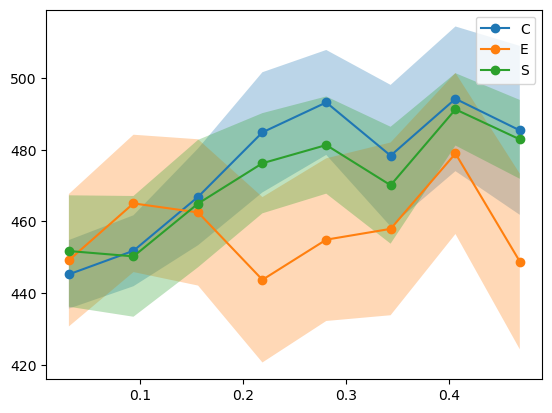

In [59]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

mdf = bdf.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


for name, group in mdf.groupby('Group'):
    plt.plot(time_intervals, group['mean'], marker='o', label=name)
    plt.fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)
plt.legend()
plt.plot()



55905


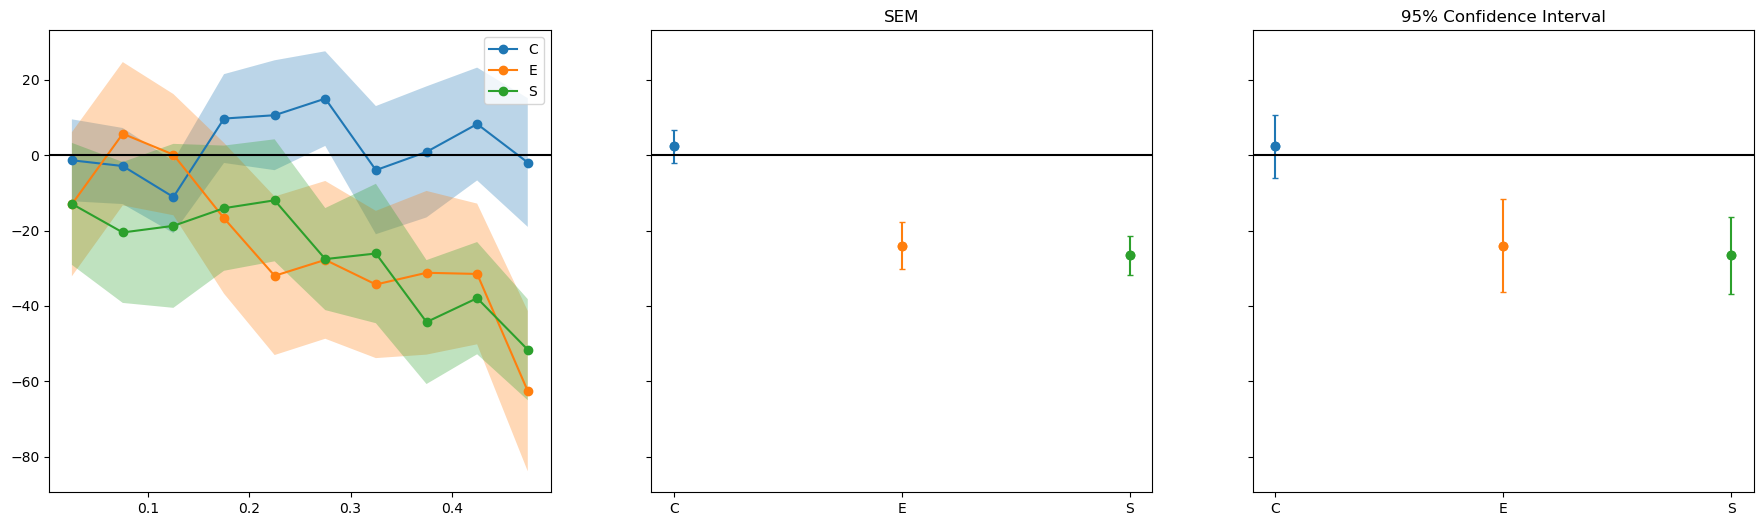

In [60]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=10)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

bdf['Age'] = pd.to_numeric(bdf['Age'], errors='coerce')
bdf['time_rel_c'] = pd.to_numeric(bdf['time_rel_c'], errors='coerce')

bdf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * bdf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-bdf['Age'] / total_coefs[4])) * bdf['time_rel_c']
)

bdf['Slope_rel'] = bdf['Slope'] - bdf['Slope_n']

mdf = bdf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()
mdf_t = bdf.groupby(['Group'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [61]:
model = Lmer('Slope_rel ~ time_rel_c*Age*Group + (1|Subject)', data=bdf)
model.fit()



print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "time_rel". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Birthdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Testdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel_c*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 460	 Groups: {'Subject': 46.0}

Log-likelihood: -2302.706 	 AIC: 4633.412

Random effects:

                 Name       Var     Std
Subject   (Intercept)  3124.849  55.900
Residual               1304.176  36.113

No random effect correlations specified

Fixed effects:

                         Estimate      2.5_ci     97.5_ci          SE  \
(Intercept)             -2.761032  -59.129278   53.607214   28.759838   
time_rel_c              27.009826  -48.892125  102.911776   38.726197   
Age                      0.100905   -1.535931    1.737740    0.83

In [62]:
# DATA

# x is a matrix one column per participant, one row per time  70 * 8
# age is a vector of 70 * 1 values
# group is a matrix of one column per participant, 70 * 3 rows (is_control, is_enc, is_sq)

# X is a matrix with all data above:  70 * 12(8+1+3) 

# PARAMETERS
# mi is a vector of 70 values
# mage is a scalar
# mgroup is a vector of 3 values (control, enc, sq)


# Y = 8*70



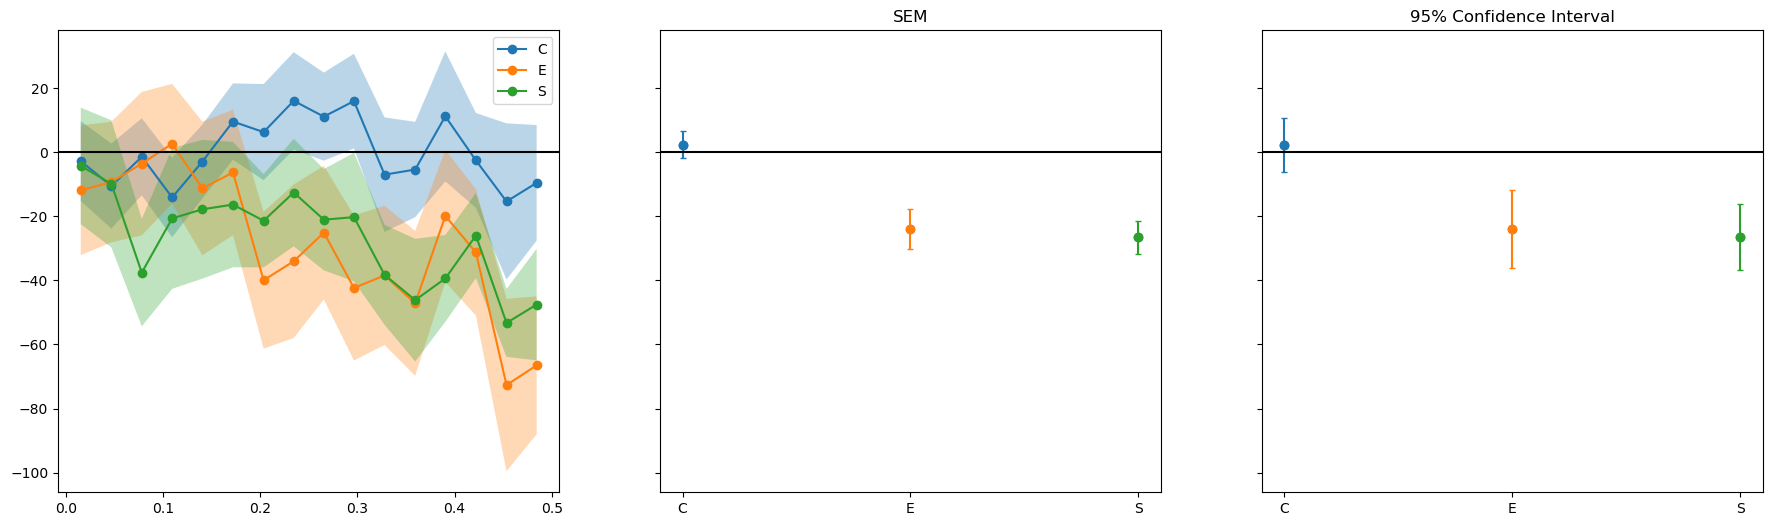

In [63]:
daf = data_allF.copy()
daf = daf[daf['Session']==1]
daf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * daf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-daf['Age'] / total_coefs[4])) * daf['time_rel']
)

daf['Slope_rel'] = daf['Slope'] - daf['Slope_n']
bdaf = daf.copy()
bdaf['time_rel'] = pd.cut(bdaf['time_rel'], bins=16)  
bdaf = bdaf.groupby(['Session','Subject','time_rel'])['Slope_rel'].mean().reset_index()
bdaf['Group'] = bdaf['Subject'].str[0]
bdaf["time_rel_c"] = bdaf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdaf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdaf = bdaf.merge(age)

bdaf['Age'] = pd.to_numeric(bdaf['Age'], errors='coerce')
bdaf['time_rel_c'] = pd.to_numeric(bdaf['time_rel_c'], errors='coerce')

mdaf = bdaf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdaf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [64]:
mdaf.head()


Group           time_rel       mean        sem
0     C  (-0.0005, 0.0312]  -2.804151  12.460972
1     C   (0.0312, 0.0625] -10.586928  13.259478
2     C   (0.0625, 0.0938]  -1.451132  12.005949
3     C    (0.0938, 0.125] -14.155668  12.382598
4     C     (0.125, 0.156]  -2.952729  11.532108

In [65]:
mdf.head()


Group         time_rel       mean        sem
0     C  (-0.0005, 0.05]  -1.350381  10.873218
1     C      (0.05, 0.1]  -2.873561  10.096132
2     C      (0.1, 0.15] -11.105171   9.575169
3     C      (0.15, 0.2]   9.730121  11.787842
4     C      (0.2, 0.25]  10.612531  14.585630

In [66]:
model = Lmer('Slope_rel ~ time_rel*Age*Group + (1|Subject)', data=daf)
model.fit()


print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 55905	 Groups: {'Subject': 46.0}

Log-likelihood: -368794.558 	 AIC: 737617.116

Random effects:

                 Name        Var      Std
Subject   (Intercept)   3281.680   57.286
Residual               31356.028  177.076

No random effect correlations specified

Fixed effects:

                       Estimate      2.5_ci     97.5_ci         SE  \
(Intercept)           -4.385010  -58.983505   50.213486  27.856887   
time_rel              82.682770   44.595235  120.770304  19.432773   
Age                    0.127103   -1.472917    1.727123   0.816352   
GroupE                63.864787  -35.633296  163.362869  50.765261   
GroupS               -59.303790 -232.943808  114.336228  88.593474   
time_rel:Age          -1.607519   -2.930283   -0.284755   0.674892   
time_rel:GroupE     -172.896691 -239.852263 -105.941119  34.161634   

In [67]:
bdf.head()



Session Subject         time_rel       Slope Group  time_rel_c  \
0        1     C02  (-0.0005, 0.05]  424.726181     C     0.02475   
1        1     C02      (0.05, 0.1]  469.356974     C     0.07500   
2        1     C02      (0.1, 0.15]  479.080971     C     0.12500   
3        1     C02      (0.15, 0.2]  485.815636     C     0.17500   
4        1     C02      (0.2, 0.25]  529.244099     C     0.22500   

             Birthdate             Testdate    Age     Slope_n  Slope_rel  
0  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  455.657345 -30.931163  
1  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  462.945540   6.411434  
2  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  470.197475   8.883495  
3  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  477.449411   8.366225  
4  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  484.701346  44.542752

 _____________ Fitted Parameters A:
a: -4865.4706654032025
b: -5663.018032477318
c: 999.999999998639
 _____________ Fitted Parameters B:
a: -5312.467160594859
b: -5703.783075203628
c: 999.9999999999342
 _____________ Fitted Parameters C:
a: 1.5561518617094878
b: -4.16923489455416e-10
c: 10.56241005482525


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Slope analysis')

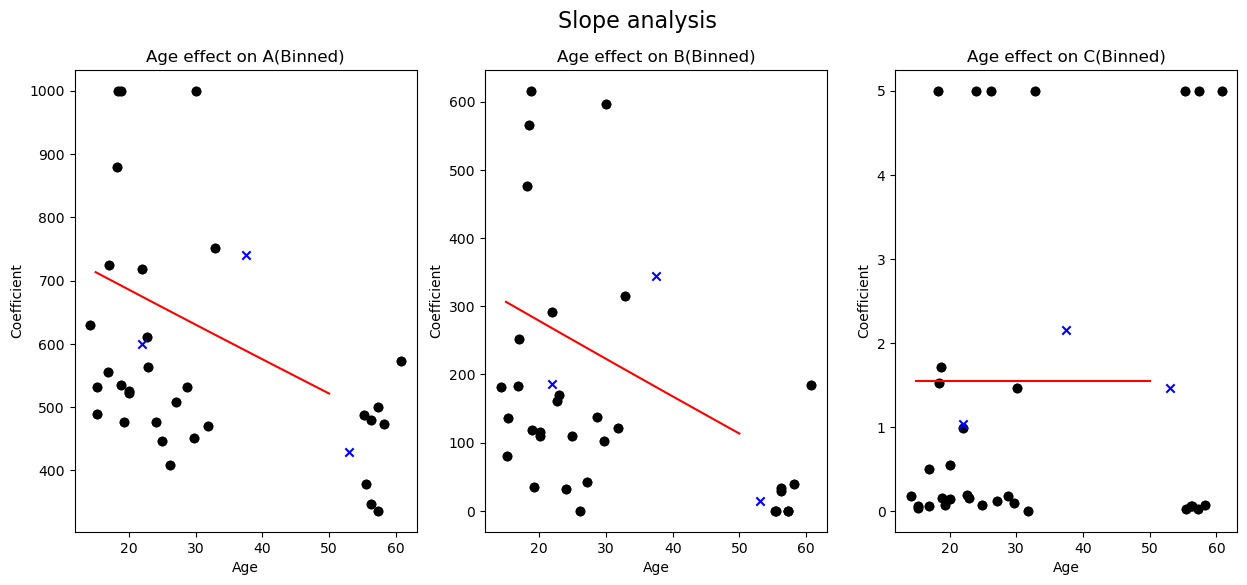

In [68]:

#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c)) 




x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]
    

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)
   

fig, ax = plt.subplots(1, 3, figsize = (15, 6))


splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 3
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])
    


    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



C34_1
[17.528571428571425, 24.185714285714283, 30.842857142857138, 37.49999999999999, 44.15714285714285, 50.81428571428571, 57.47142857142857]
[183.82357463616324, 140.08577559542354, 182.0144627234479, nan, nan, nan, 102.00332080584387]


/tmp/ipykernel_2645804/1853264264.py:66: RuntimeWarning: Mean of empty slice.
  bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: array must not contain infs or NaNs

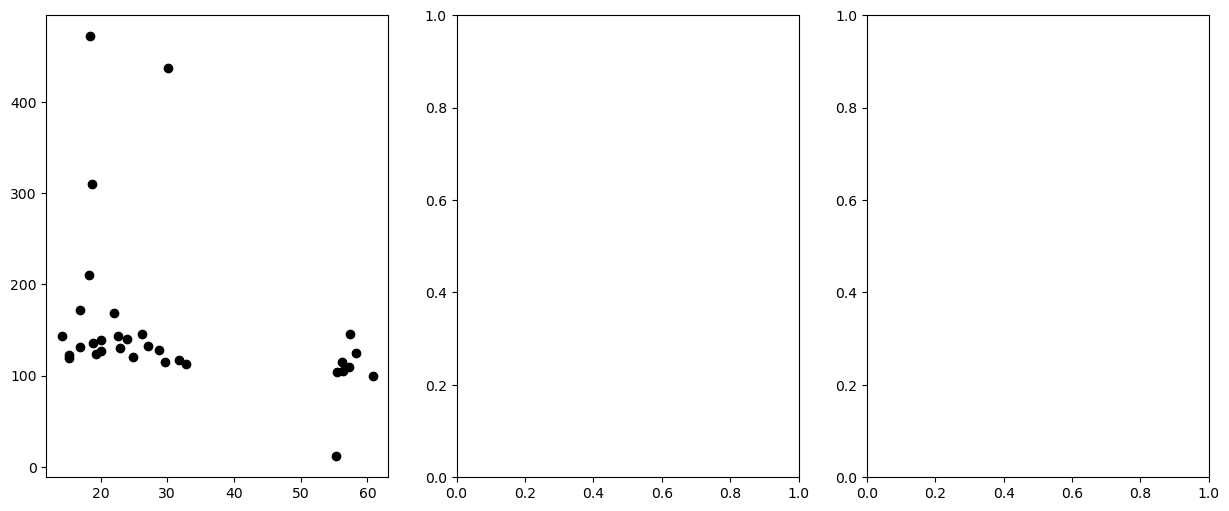

In [72]:
#LOG NO BINS AMPLITUDE


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.PTP.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,-1000,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    print(name)
    print(bin_centers)
    print(bin_means)

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)


 _____________ Fitted Parameters A:
a: 334.9040782477771
b: -4406.184268456695
c: 5.867572042923727
 _____________ Fitted Parameters B:
a: 274.59478448567137
b: -5419.125655398072
c: 6.027382406313883
 _____________ Fitted Parameters C:
a: -13.176671339495577
b: -13.876082661935177
c: 999.99999999961


Text(0.5, 0.98, 'Amplitude analysis')

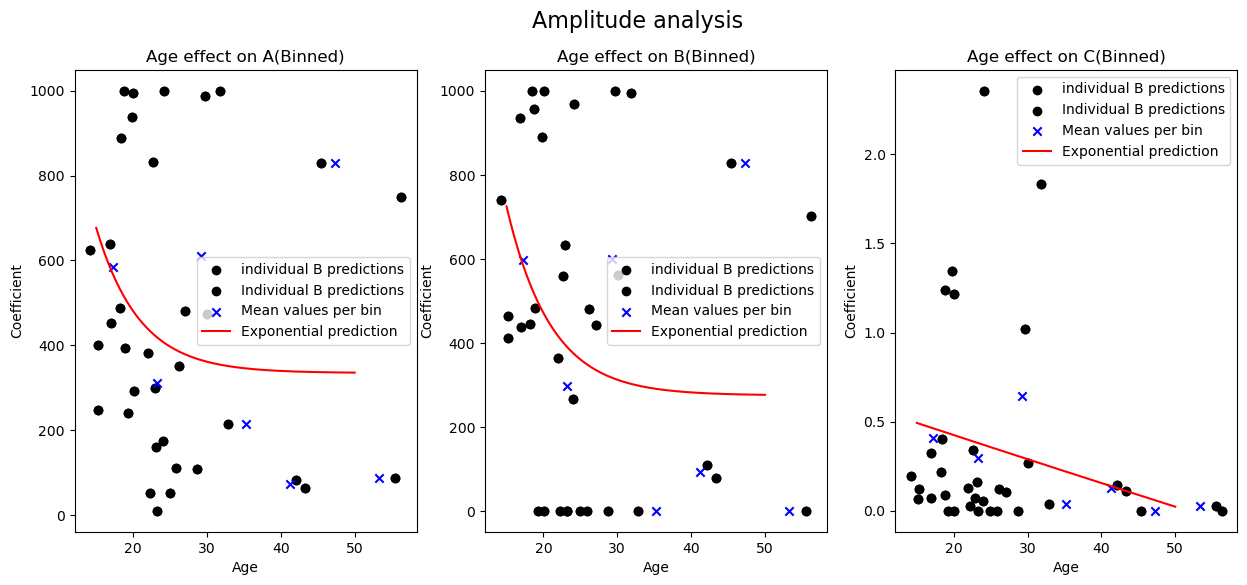

In [ ]:
#LOG NO BINS NUMBER


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)

    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=8)  # Adjust the number of bins as needed
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].count().reset_index()
    bdf_c['Group'] = bdf_c['Subject'].str[0]
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid).astype('object')
    times_Subject = bins_Subject['time_rel_c'].unique()
    
    x = bins_Subject.time_rel_c.values
    y = bins_Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    if popt[2] > 4:
        popt[2] = 0

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)

NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN


/tmp/ipykernel_2404168/2289991859.py:16: RuntimeWarning: overflow encountered in exp
  return a  + (b * np.exp(-x/c))


[]

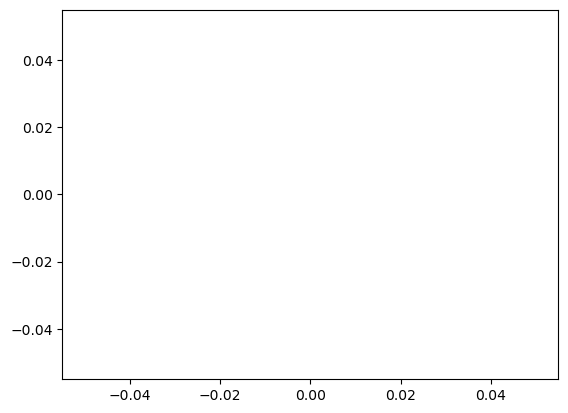

In [ ]:
#LOG WITH BINS




#CONTROL SWA found

bdf_c = bdf_c

bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
bdf_c['sAge'] = bdf_c['Age']/50


def func(x, a, b, c):

    return a  + (b * np.exp(-x/c))


for name, Subject in bdf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel_c.values
    y = Subject.Slope.values
    
    try:
        popt, pcov = curve_fit(func, x, y)
    

        #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
        coef = popt[1]
        #age = Subject['sAge'].unique()[0]
        plt.scatter(age,coef, color='black')

    except:
        print('NAN')

    #print(Subject['sAge'].unique()[0])
    #print(coef)
   
    
    
plt.plot()

C25_1
[0.037214 0.11249999999999999 0.1875 0.2625 0.3375 0.4125
 0.48750000000000004 0.5625]
524.6312083408473
-36.83694223891581
0.1114008015903066


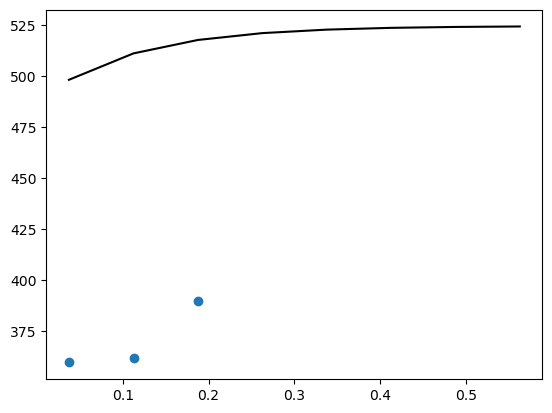

In [ ]:
print(name)
plt.scatter(Subject.time_rel_c,Subject.Slope.values)
print(x)
print(popt[0])
print(popt[1])
print(popt[2])
x = Subject.time_rel_c.values.astype(float)
plt.plot(x, func(x,popt[0],popt[1],popt[2]), color='black')

## SQRT PRED PLOT

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]

daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ sqrt_t', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ sqrt_t * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ sqrt_t * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()





IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## LINE PRED PLOT

/tmp/ipykernel_2747101/2835078309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2835078309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50
/tmp/ipykernel_2747101/2835078309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2047	 R^2: 0.001	 R^2_adj: 0.000

Log-likelihood: -13446.054 	 AIC: 26896.108	 BIC: 26907.356

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 902	 R^2: 0.003	 R^2_adj: 0.001

Log-likelihood: -5807.964 	 AIC: 11619.929	 BIC: 11629.538

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 466	 R^2: 0.003	 R^2_adj: 0.000

Log-likelihood: -2972.719 	 AIC: 5949.438	 BIC: 5957.726

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2500	 R^2: 0.002	 R^2_adj: 0.001

Log-likelihood: -16762.757 	 AIC: 33529.515	 BI

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1130	 R^2: 0.000	 R^2_adj: -0.001

Log-likelihood: -7311.558 	 AIC: 14627.116	 BIC: 14637.176

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1701	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -10866.761 	 AIC: 21737.521	 BIC: 21748.399

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4434	 R^2: 0.024	 R^2_adj: 0.024

Log-likelihood: -29964.563 	 AIC: 59933.127	 BIC: 59945.921

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2443	 R^2: 0.000	 R^2_adj: -0.000

Log-likelihood: -15994.865 	 AIC: 31993.

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:25: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel*(sAge)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.056	 R^2_adj: 0.056

Log-likelihood: -471102.749 	 AIC: 942213.498	 BIC: 942250.174

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.059	 R^2_adj: 0.059

Log-likelihood: -471007.692 	 AIC: 942027.384	 BIC: 942082.397

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2+sAge3)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.061	 R^2_adj: 0.061

Log-likelihood: -470926.638 	 AIC: 941869.275	 BIC: 941942.626

Fixed effects:



/tmp/ipykernel_2747101/2835078309.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(sAge_values, model3.coefs['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][5]*sAge_values
/tmp/ipykernel_2747101/2835078309.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][6]*sAge_values2
/tmp/ipykernel_2747101/2835078309.py:45:

Formula: Slope~time_rel*(sAge+sAge2+sAge3+sAge4)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.062	 R^2_adj: 0.062

Log-likelihood: -470896.791 	 AIC: 941813.582	 BIC: 941905.270

Fixed effects:



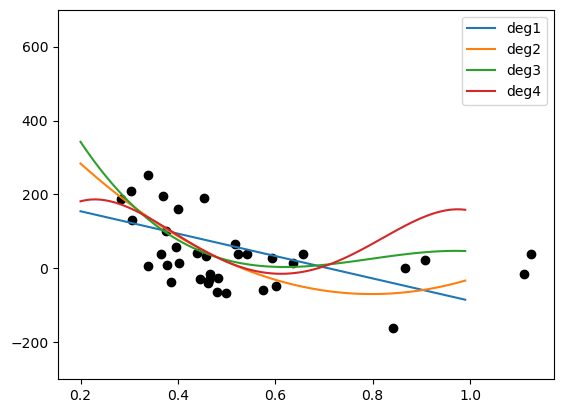

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ time_rel', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ time_rel * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ time_rel * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()


## LOG PRED PLOT

/tmp/ipykernel_2747101/38719194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/38719194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


36
36
36


[]

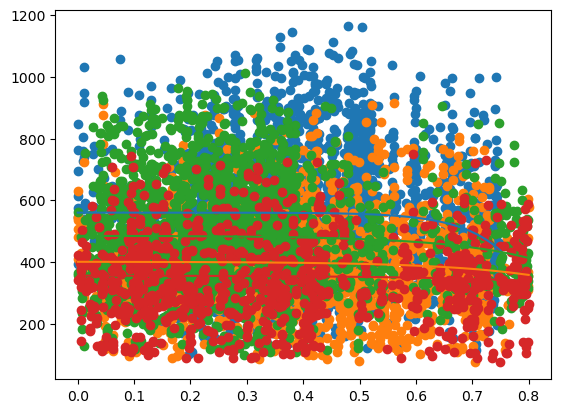

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50




def func(x, a, b, c):
    return a  + (b * np.exp(-x/c))

c = 0
f = 0
g = 0

for name, Subject in daf_c.groupby('Id'):
    c = c +1

    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values

      
    popt, pcov = curve_fit(func, x, y)
    g = g + 1
    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef = 1/popt[1]
    #age = Subject['sAge'].unique()[0]
    #plt.scatter(age,coef, color='black')

    f = f + 1
    #print(Subject['sAge'].unique()[0])
    #print(coef)

    if coef < -1:
        plt.scatter(Subject.time_rel.values,Subject.Slope.values)
        plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    
    
print(c)
print(f)
print(g)
    
plt.plot()

# NO BINS MODEL

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c.head()

/tmp/ipykernel_2747101/2859326843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2859326843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
47  2831880  12769  0.673000  2423.08      2423.34  2423.57  2423.91   
48  2830582  11471  0.679381  2446.06      2446.33  2446.52  2447.30   
49  2833475  14364  0.679381  2446.04      2446.28  2446.48  2446.75   
50  2835266  16155  0.679381  2446.03      2446.27  2446.47  2446.75   
51  2836802  17691  0.679381  2446.02      2446.25  2446.47  2446.79   

    Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
47      1.11  -46.707747   32.177395   78.885141  303.404390   0.900901   
48      1.53  -89.754462   38.805616  128.560078  476.148436   0.653595   
49      0.98 -117.820316   70.414380  188.234695  784.311231   1.020408   
50      0.98 -111.116778   73.118567  184.235346  767.647273   1.020408   
51      1.02  -55.017271   42.728858   97.746129  424.983169   0.980392   

    Stage Channel  IdxChannel Group Subject Session    Age Machine  \
47      3      F3           7     C     C02       1  22.91       O   
48      3      F7           6     C     C02       1  22.91       O   
49      3      Fz           8     C     C02       1  22.91       O   
50      3      F4           9     C     C02       1  22.91       O   
51      3      F8          10     C     C02       1  22.91       O   

   ConfArousal Position  N3_times  time_rel     Id    sAge  
47           0        F     0.673  0.000000  C02_1  0.4582  
48           0        F     0.673  0.006381  C02_1  0.4582  
49           0        F     0.673  0.006381  C02_1  0.4582  
50           0        F     0.673  0.006381  C02_1  0.4582  
51           0        F     0.673  0.006381  C02_1  0.4582

(array([7629., 2848., 7436., 3114., 9113., 7836.,    0., 3870., 9012.,
        2762.,  492., 3834., 3674.,  902.,  466., 2500., 1130., 1701.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   88.,
         419.,    0.,  256.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1803.]),
 array([0.284  , 0.30505, 0.3261 , 0.34715, 0.3682 , 0.38925, 0.4103 ,
        0.43135, 0.4524 , 0.47345, 0.4945 , 0.51555, 0.5366 , 0.55765,
        0.5787 , 0.59975, 0.6208 , 0.64185, 0.6629 , 0.68395, 0.705  ,
        0.72605, 0.7471 , 0.76815, 0.7892 , 0.81025, 0.8313 , 0.85235,
        0.8734 , 0.89445, 0.9155 , 0.93655, 0.9576 , 0.97865, 0.9997 ,
        1.02075, 1.0418 , 1.06285, 1.0839 , 1.10495, 1.126  ]),
 <BarContainer object of 40 artists>)

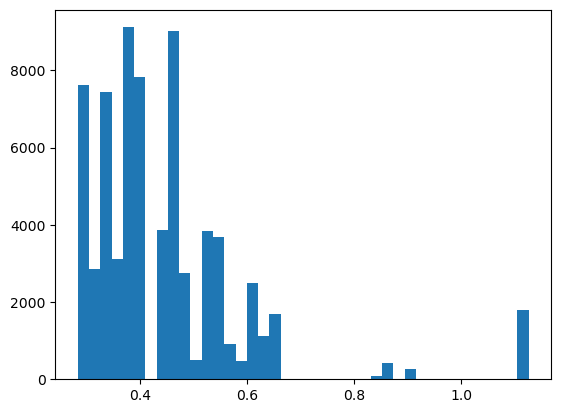

In [ ]:
plt.hist(daf_c['sAge'],40)

# UP TO deg 5

In [ ]:


model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2) + I(sAge^3) + I(sAge^4) + I(sAge^5)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2)+I(sAge^3)+I(sAge^4)+I(sAge^5))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 70885	 Groups: {'Subject:Session': 36.0}

Log-likelihood: -468538.719 	 AIC: 937105.439

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   2783.254   52.757
Residual                      32268.013  179.633

No random effect correlations specified

Fixed effects:

                        Estimate         2.5_ci        97.5_ci             SE  \
(Intercept)           545.230148   -4205.704435    5296.164730    2423.990757   
time_rel              650.151609   -1359.763086    2660.066304    1025.485525   
sAge                 2439.862933  -40785.782097   45665.507963   22054.305779   
I(sAge^2)          -18231.543279 -168347.025651  131883.939093   76590.939199   
I(sAge^3)           44263.778946 -204135.601478  292663.159371  126736.706585   
I(s

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-182.42663567,   -9.98758106,  298.17521341, ...,   79.22585185,
         53.6560655 ,  190.42256289])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

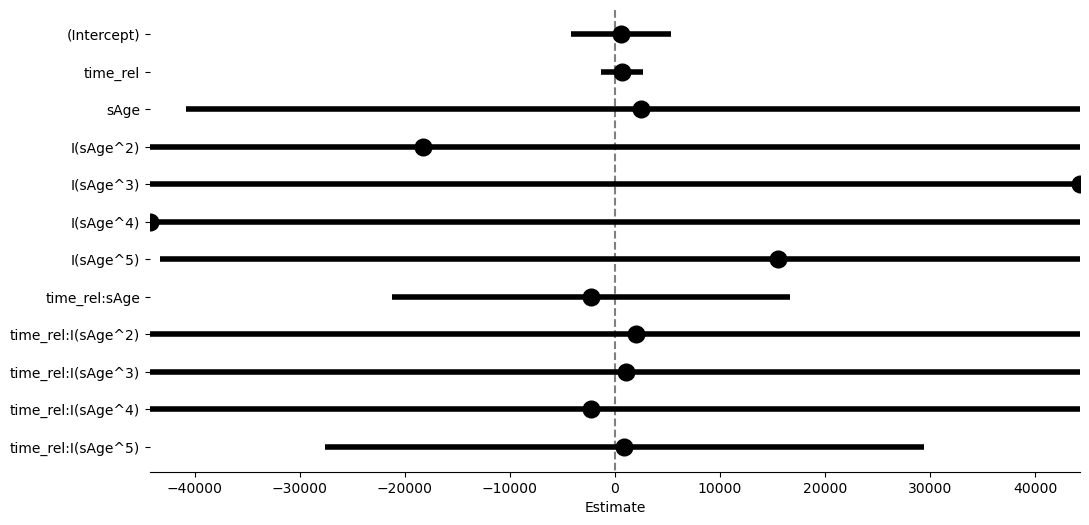

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)

    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


ValueError: Length of values (70885) does not match length of index (15362)

<Figure size 1000x600 with 0 Axes>

# Up to 2 deg BOTH

In [ ]:
model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2)) + I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2))+I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102381.231 	 AIC: 204784.462

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3953.781   62.879
Residual                      36005.746  189.752

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   305.326359  -195.244724   805.897442   
time_rel                      -28.407445 -1186.611038  1129.796147   
sAge                           82.758625 -1890.453768  2055.971018   
I(sAge^2)                     148.229150 -1690.067729  1986.526028   
I(sqrt(time_rel))             813.992976  -606.018835  2234.004788   
time_rel:sAge                -603.437313 -5307.231487  4100.3568

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-247.15359379,  -48.63753464,   16.24605027, ...,  338.3323455 ,
        -76.30385387, -163.44301389])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

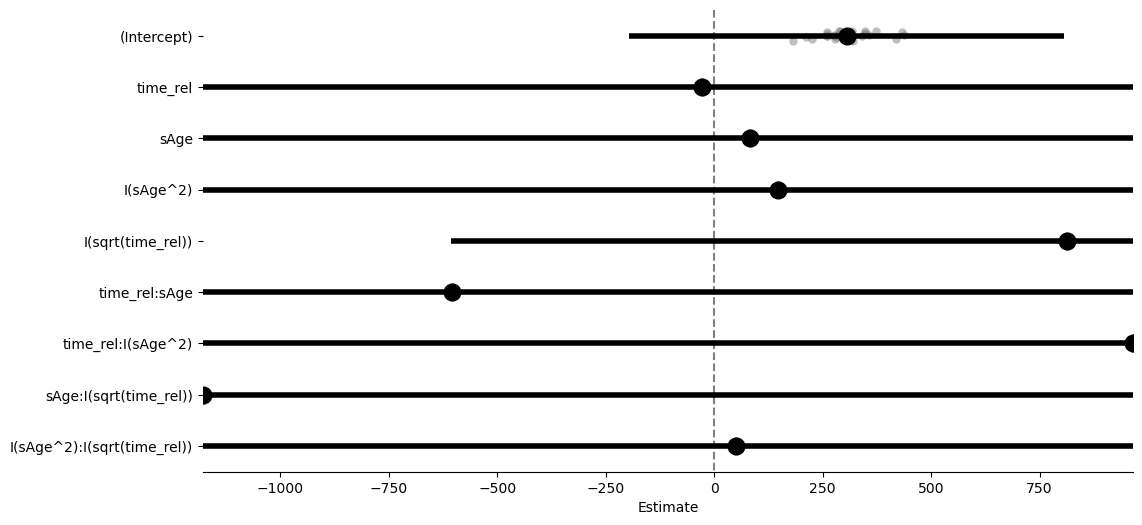

In [ ]:
model_sq.plot_summary()

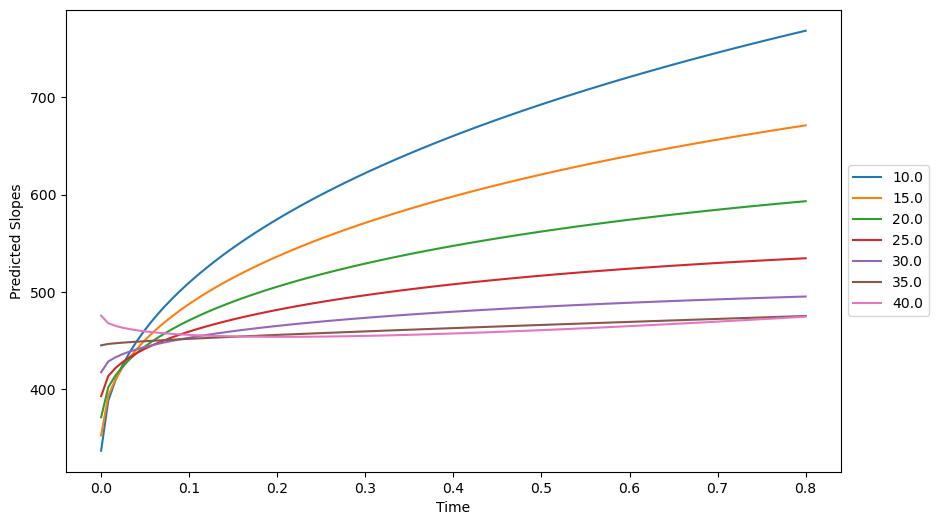

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


# SQRT 5 Deg BOTH

In [ ]:


model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2) +  I(sAge^3)) + time_rel * (sAge + I(sAge^2) + I(sAge^3)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2)+I(sAge^3))+time_rel*(sAge+I(sAge^2)+I(sAge^3))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102349.974 	 AIC: 204727.949

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3606.192   60.052
Residual                      36006.367  189.753

No random effect correlations specified

Fixed effects:

                                 Estimate        2.5_ci        97.5_ci  \
(Intercept)                     36.922543  -1799.604734    1873.449820   
I(sqrt(time_rel))             4522.657768   -701.952485    9747.268022   
sAge                          1904.851570  -9224.171641   13033.874781   
I(sAge^2)                    -3669.305727 -24993.713699   17655.102246   
I(sAge^3)                     2442.506488 -10357.671495   15242.684472   
time_rel            

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-258.63390099,  -57.65674197,   10.43682056, ...,  336.66618106,
        -77.97283668, -165.11606538])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

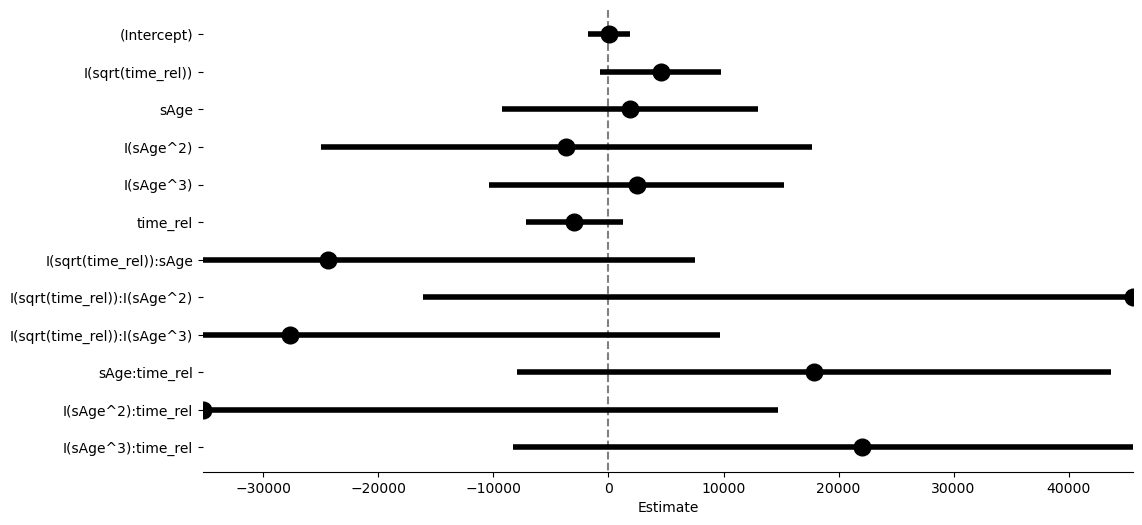

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

ValueError: operands could not be broadcast together with shapes (15362,) (123921,) 

<Figure size 1000x600 with 0 Axes>

# SQRT deg 2

In [ ]:
model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 123921	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -818610.531 	 AIC: 1637237.061

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   4269.829   65.344
Residual                      31984.732  178.843

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   332.977855    58.379422   607.576289   
I(sqrt(time_rel))             644.881553   550.828292   738.934814   
sAge                           69.927264  -975.555671  1115.410200   
I(sAge^2)                     -11.091886  -945.498875   923.315104   
I(sqrt(time_rel)):sAge      -1453.831688 -1854.669336 -1052.994040   
I(sqrt(time_rel)):I(sAge^2)   913.942258   505.618396  1322.266121   

                 

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([  96.03910818,  119.93726911, -146.7354911 , ..., -129.03346606,
       -166.11564097, -278.91066559])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

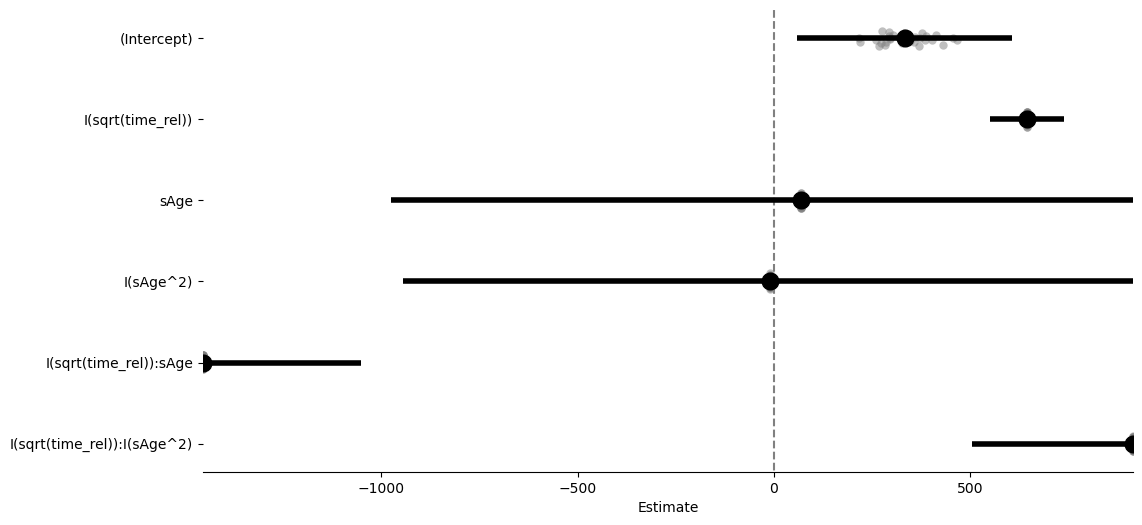

In [ ]:
model_sq.plot_summary()

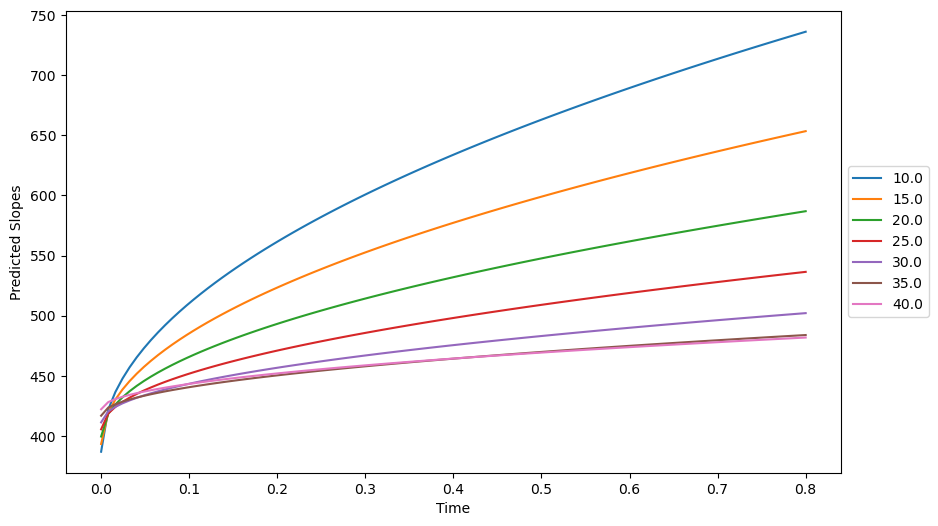

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   